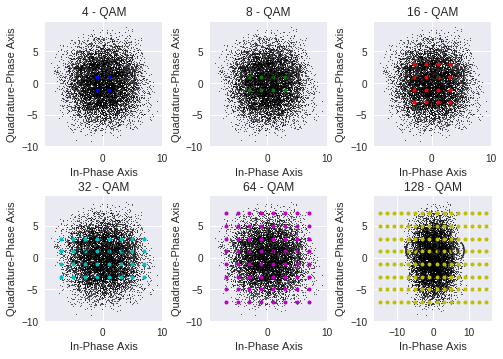

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import itertools as iter
from scipy.cluster.vq import kmeans, whiten, vq
from scipy.spatial.distance import cdist
import random
import math

file_path = "EM_data.npy"

observed_noisy_data = np.load(file_path)
observed_data = np.concatenate((observed_noisy_data.real, observed_noisy_data.imag), axis=1)
m_qam_range = [4, 8, 16, 32, 64, 128]
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
col = iter.cycle(color_list)

def construct_mqam(m: int):
    """Function to build M-QAM constellation values"""
    # gray_vals = dec2gray([i for i in range(m)])
    if np.log2(m) / 2 != np.log2(m) // 2:
        dx = int(np.sqrt(2 * m))
        dy = int(np.sqrt(m / 2))
    else:
        dx = dy = int(np.sqrt(m))
    real = np.array(np.reshape([i for i in range(dx)] * dy, (dy, dx)))
    imag = np.transpose(np.reshape([i for i in range(dy)] * dx, (dx, dy)))
    constell = real * 2 - np.amax(real) + 1j * (imag * 2 - np.amax(imag))
    constell[1::2] = np.fliplr(constell[1::2])
    return np.reshape(constell, m)

m_qam_const = [construct_mqam(x) for x in m_qam_range]

def plot_for_various_k_means():
  fig = plt.figure()
  fig.subplots_adjust(hspace=0.4, wspace=0.4)
  for i in range(1, 7):
      a = m_qam_const[i-1]
      ax = fig.add_subplot(2, 3, i)
      ax.text(0.5, 0.5, str((2, 3, i)),
             fontsize=18, ha='center')
      plt.scatter(observed_noisy_data.real, observed_noisy_data.imag, c='black', s=0.3)
      plt.plot(a.real, a.imag, 'o' + next(col), markersize=4)
      plt.xlabel('In-Phase Axis')
      plt.ylabel('Quadrature-Phase Axis')
      plt.title('%d - QAM' % len(a))
  plt.show()

plot_for_various_k_means()

Appears that outputs are noisy versions from a 64-QAM.
Running K means for K=64 values and 1000 iterations. Plot the estimated means alongside with the ground truth.


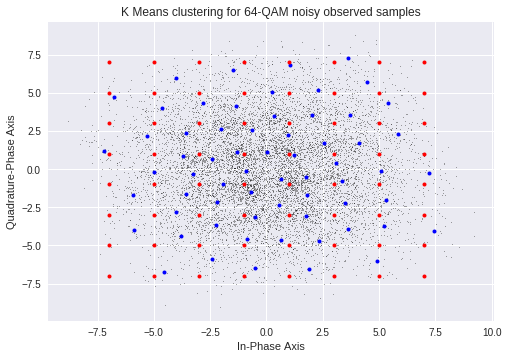

In [4]:
M = 64
def get_k_means_centroids(K):
  idx = m_qam_range.index(K)
  a = m_qam_const[idx]
  initial_centroid = a.reshape(len(a), 1) # Complex vector of Initial Centroids.
  initial_centroid_2d = np.concatenate((initial_centroid.real, initial_centroid.imag), axis=1) # Reconstruction into a 64X2 matrix with Real part in first column & imaginary in 2nd
  centroids, labels = kmeans(observed_data, initial_centroid_2d, iter=1000)
  return centroids, labels, a

"""Plot the estimated centroids by the K-Means"""
def plot_estimated_centroids():
  centroids,_,a = get_k_means_centroids(M)
  plt.figure(1)
  plt.grid(True)
  plt.plot(observed_data[:, 0], observed_data[:, 1], 'ok', markersize=0.5)
  plt.plot(centroids[:, 0], centroids[:, 1], 'ob', markersize=4)
  plt.plot(a.real, a.imag, 'or', markersize=4)
  plt.xlabel('In-Phase Axis')
  plt.ylabel('Quadrature-Phase Axis')
  plt.title('K Means clustering for 64-QAM noisy observed samples')
  plt.show()

plot_estimated_centroids()

Given estimated centroids representing noisy versions for the corresponding
true QAM inputs, calculate the initial model parameters i.e. delta,  variance of noise and probability distribution. It's important to note that poise power of zero mean Gaussian Noise is equal to it's variance, which will be used for variance calculation.

Also, considering each input symbol from the constellation of 64-QAM to be equally likely, assume uniform probability distribution.

In [0]:
def calc_initial_theta(ground_truth_qam, complex_centroids):
  SNRdB = 10 # Assume SNRdb to be 10
  SNR = 10 ** (-SNRdB/10)
  PowX = np.mean(np.absolute(ground_truth_qam)**2)
  PowN = PowX * SNR # Noise Power

  noise_variance_initial = PowN / 2 # sigma^2 of AWGN. For complex it's Power/2
  noise = np.sqrt(noise_variance_initial) * (np.random.randn(128,).view(np.complex))
  delta_initial = np.true_divide(np.subtract(complex_centroids, noise), ground_truth_qam)
  abs_delta_initial = np.mean(np.abs(delta_initial)) 
  
  Px = (1/64) * np.ones((64,), dtype=int) # Uniform distribution
  theta = [abs_delta_initial, noise_variance_initial, Px]
  return theta

def closest_node(node, nodes):
    closest_index = cdist([node], nodes).argmin()
    return nodes[closest_index]

Initialization of the EM algorithm goes below. We first compute the auxilliary distribution function and start with our initial model parameter vector θ<sup>o</sup> = (abs_delta_initial, noise_variance, Px). Using evaluated distribution, we then maximize this distribution for model parameters to get next set of θ<sup>t</sup>'s. These steps are iteratively repeated until convergance.

Various Probability Distributions defined for this case:

 \begin{equation}
 P_{Y |X}(y|x; \underlineθ) =\frac{1}{\sqrt{2\pi\sigma^2}} . exp^\frac{-|y-Δx|^2}{2\sigma^2}
\end{equation}

Auxilliary Distribution function:

\begin{equation}
Q_{X_i}^{(t)}(x) = \frac {P_{Y/X}(y_i/x; \underlineθ^{(t-1)}).P_X(x;\underlineθ^{(t-1)})}{P_Y(y_i;\underlineθ^{(t-1)})}
\end{equation}

Here, it's important to show that distrinution P<sub>Y</sub>:

\begin{equation}
P_Y(y_i;\underlineθ) = \sum_{x \epsilon X}P_{Y/X}(y_i/x; \underline\theta).P_X(x;\underline\theta)
\end{equation}

Thus, Maximization steps results in the following:

\begin{equation}
\sum_{i=1}^{N}\sum_{x \epsilon X}Q_{X_i}^{(t)}(x) log(P_{Y|X}(y_i|x; \underline {\theta})P_X(x:\underline\theta))
\end{equation}

Hence, calculated model parameter maximizers for each iterative steps look as:

\begin{equation}
\Delta^{(t+1)} = \frac{\sum_{i=1}^{N} \sum_{x \epsilon X}Q_{X_i}^{(t)}(x)y_ix}{\sum_{i=1}^{N} \sum_{x \epsilon X}Q_{X_i}^{(t)}(x)|x|^2}
\end{equation}


\begin{equation}
\sigma^{2,(t+1)} = \frac{1}{N} \sum_{i=1}^{N} \sum_{x \epsilon X}Q_{X_i}^{(t)}(x)|y_i - \Delta^{(t+1)}x|^2 
\end{equation}


\begin{equation}
p_j^{(t+1)} = \frac{1}{N} \sum_{i=1}^{N}Q_{X_i}^{(t)}(x_j)  
\;\;\;\forall \;j = 1,2,...,M
\end{equation}



In [28]:
num_iters = 30
stop = False
"""
The E-step. Keeps parameter vector constant & evaluates auxilliary distribution
"""   
def calc_qxi(y, theta_vector, a):
  qxi = np.zeros((len(y), M))
  pyi = np.zeros((M,1))
  for i in range(len(y)):
      for j in range(M):
        exponent = np.true_divide(np.abs(np.subtract(y[i], (theta_vector[0] * a[j]))) ** 2, 2 * (theta[1] ** 2))
        pyi_given_x = (1/np.sqrt(2*np.pi*(theta_vector[1] ** 2))) * (np.e ** (-1 * exponent))
        px = theta_vector[2][j]
        pyi[j] = pyi_given_x * px
      tot_pyi = np.sum(pyi)
      qxi[i] = np.true_divide(pyi.reshape(1, len(pyi)), tot_pyi)
  return qxi

def max_qxi(qxi, a):
  theta_n = [0]
  delta_nr = 0
  delta_dr = 0
  for i in range(len(observed_noisy_data)):
    delta_nr += np.sum(qxi[i,:] * np.abs(observed_noisy_data[i] * a))
    delta_dr += np.sum(qxi[i,:] * np.abs(a)**2)
  delta_new = np.true_divide(delta_nr, delta_dr)
  
  theta_n[0] = delta_new
  
  sigma_sum = 0
  
  for i in range(len(observed_noisy_data)):
    sigma_sum += np.sum(qxi[i,:] * np.abs(observed_noisy_data[i] - (delta_new *a)) ** 2)
  theta_n.append((1/10000) * sigma_sum)
  
  px_new = np.zeros((M, 1))
  
  for i in range(M):
    px_new[i] = (1/10000) * np.sum(qxi[:,i])
  theta_n.append(px_new)
  return theta_n


  
def em(y, parameter_vector, ground_truth_qam):
  
  for i in range(num_iters):
    # E- Step
    qxi = calc_qxi(y, parameter_vector, ground_truth_qam)
    # M - Step
    parameter_vector = max_qxi(qxi, ground_truth_qam)
  
  optimised_param = {}
  optimised_param['delta'] = parameter_vector[0]
  optimised_param['sigma**2'] = parameter_vector[1]
  optimised_param['p'] = parameter_vector[2]
  return optimised_param
#   print(sum(parameter_vector[2])) # To verify sum of probabilities is 1

# Initialise parameter model & perform EM.
centroids, labels, ground_truth_qam = get_k_means_centroids(M)
complex_centroids = centroids[:, 0] + 1j * centroids[:, 1]
theta = calc_initial_theta(ground_truth_qam, complex_centroids)

print(em(observed_noisy_data, theta, ground_truth_qam))
    
  
  

{'delta': 2.6618728497751256, 'sigma**2': 8.651608540740774, 'p': array([[1.92838473e-199],
       [2.18866814e-124],
       [2.18042563e-084],
       [6.09243625e-075],
       [6.12910390e-083],
       [2.09742199e-099],
       [2.74015750e-131],
       [7.92423801e-185],
       [1.83175737e-113],
       [5.38360386e-064],
       [1.19854762e-040],
       [7.37067236e-030],
       [4.97699054e-026],
       [9.92209057e-036],
       [1.46984194e-072],
       [1.93438067e-138],
       [5.58385980e-105],
       [6.01008390e-045],
       [4.59016819e-015],
       [4.82056273e-006],
       [8.96298736e-007],
       [9.78311541e-012],
       [1.13647176e-029],
       [1.04557975e-076],
       [5.52601402e-070],
       [9.04683265e-023],
       [6.69862644e-005],
       [2.58065933e-001],
       [2.40475253e-001],
       [4.58185421e-008],
       [2.85143647e-033],
       [3.45004974e-089],
       [2.96788545e-078],
       [7.30717649e-027],
       [4.39992586e-006],
       [2.57403992e-001]